In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# Load dataset
df = pd.read_csv("weatherAUS.csv")

In [4]:
# Drop rows with missing target and missing rain today
df.dropna(subset=['RainTomorrow'], inplace=True)
df.dropna(subset=['RainToday'], inplace=True)

In [5]:
# Drop columns with more than 40% missing values
High_Missing_percentage = df.isnull().mean()
columns_to_drop = High_Missing_percentage[High_Missing_percentage > 0.4].index.tolist()
df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# Impute numerical with median
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = SimpleImputer(strategy='median').fit_transform(df[numeric_columns])

categorical_cols = df.select_dtypes(include=['object']).columns.drop('Date')
df[categorical_cols] = df[categorical_cols].fillna(method='ffill')

/var/folders/68/ym_p7n0x6sq1npn90ymtsxdw0000gn/T/ipykernel_10823/2791234806.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[categorical_cols] = df[categorical_cols].fillna(method='ffill')


In [7]:
# Encode the directional features such as 'WindGustDir', 'WindGustDir9am', and 'WindGustDir3pm' using cyclical encoding
def Cyclical_Encoding(series):
#directions to degrees mapping
    DirectionsToDegrees = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
        'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }
    #convert degrees to radians to apply sin and cosine calculations
    Radians = series.map(DirectionsToDegrees).fillna(0) * np.pi / 180
    return np.sin(Radians), np.cos(Radians)

for columns in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[f'{columns}_sin'], df[f'{columns}_cos'] = Cyclical_Encoding(df[columns])

In [8]:
# Encode the rain today and rain tomorrow features using binary encoding
df['RainToday_binary'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow_binary'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

In [9]:
# Encode the location feature using one-hot encoding
df = pd.get_dummies(df, columns=['Location'], prefix='Loca_')

In [10]:
# Drop Date column
df.drop(columns=['Date'], inplace=True)

In [11]:
# Preparing the data (after encoding all to numeric)
df_encoded = df.select_dtypes(include=[np.number])

In [12]:
# Outlier removal using IQR
numeric_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop('RainTomorrow_binary')
Q1 = df_encoded[numeric_columns].quantile(0.25)
Q3 = df_encoded[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
Lower_limit = Q1 - 1.5*IQR
Upper_limit = Q3 + 1.5*IQR
df_final = df_encoded[~((df_encoded[numeric_columns] < (Lower_limit)) | (df_encoded[numeric_columns] > (Upper_limit))).any(axis=1)]

In [13]:
# Split features and target
X = df_final.drop(columns='RainTomorrow_binary')
Y = df_final['RainTomorrow_binary']

In [14]:
# Oversample minority class
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, Y)

In [15]:
# Scale the features
feature_scaler = StandardScaler()
Scaled_X = feature_scaler.fit_transform(X_smote)

In [16]:
# Split dataset - Decision Tree
X_train, X_test, y_train, y_test = train_test_split(Scaled_X, y_smote, test_size=0.21, random_state=51)

In [17]:
# Entropy-based Decision Tree (Information Gain)
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=54)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)

print("\nInformation Gain (Entropy) Decision Tree ")
print("\n ")
print("Accuracy:", accuracy_score(y_test, y_pred_entropy))
print("\n ")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_entropy))
print("\n ")
print("Classification Report:\n", classification_report(y_test, y_pred_entropy, target_names=["No Rain", "Rain"]))
print("\n ")
print('accuracy is',accuracy_score(y_pred_entropy,y_test))


Information Gain (Entropy) Decision Tree 

 
Accuracy: 0.8825262914596094

 
Confusion Matrix:
 [[15000  2142]
 [ 1924 15546]]

 
Classification Report:
               precision    recall  f1-score   support

     No Rain       0.89      0.88      0.88     17142
        Rain       0.88      0.89      0.88     17470

    accuracy                           0.88     34612
   macro avg       0.88      0.88      0.88     34612
weighted avg       0.88      0.88      0.88     34612


 
accuracy is 0.8825262914596094


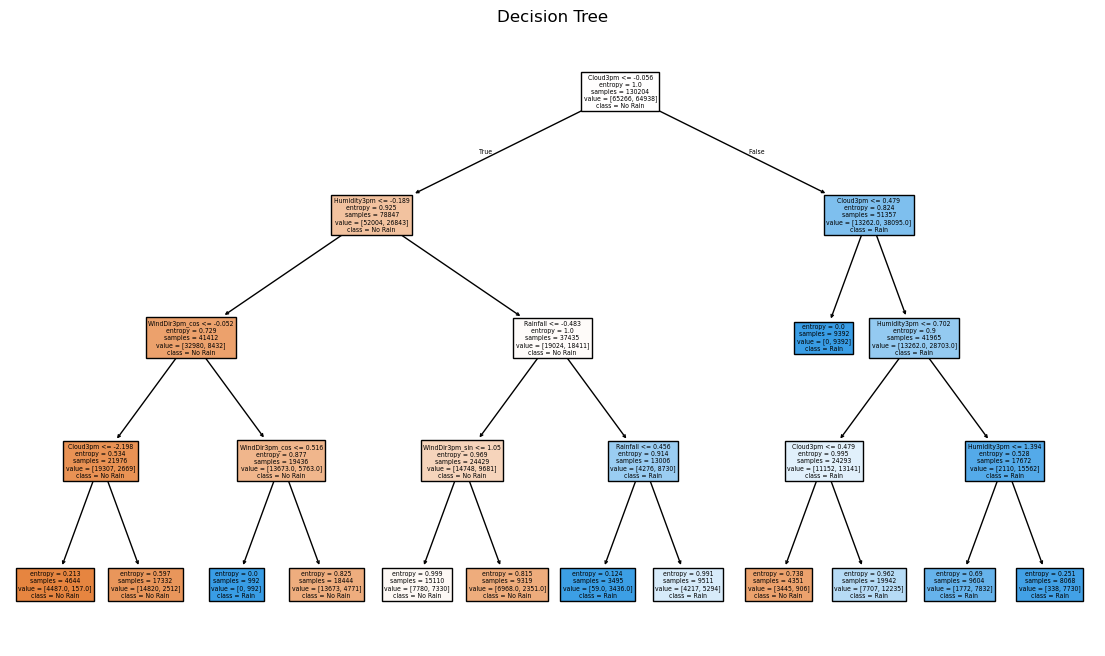

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

dt_entropy = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    min_samples_split=10,    
    min_samples_leaf=5,      
    random_state=54
)

dt_entropy.fit(X_train, y_train)
plt.figure(figsize=(14, 8))
plot_tree(dt_entropy, feature_names=df_encoded.columns, class_names=["No Rain", "Rain"], filled=True)
plt.title("Decision Tree")
plt.show()

In [19]:
# Split dataset - K-Nearest Neighbour
X_train, X_test, y_train, y_test = train_test_split(Scaled_X, y_smote, test_size=0.41, random_state=51)

In [20]:
#K-Nearest Neighbour (K = 4)
from sklearn.neighbors import KNeighborsClassifier

KNN_Classify = KNeighborsClassifier(n_neighbors = 4)
KNN_Classify.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [21]:
#K-Nearest Neighbour (K = 4)
y_pred_KNN = KNN_Classify.predict(X_test)
Accuracy_KNN = accuracy_score(y_test,y_pred_KNN)
print('Accuracy :',Accuracy_KNN)
print(classification_report(y_test,y_pred_KNN))
confusion_matrix(y_test,y_pred_KNN)

Accuracy : 0.8755604883462819
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     33695
           1       0.85      0.91      0.88     33880

    accuracy                           0.88     67575
   macro avg       0.88      0.88      0.88     67575
weighted avg       0.88      0.88      0.88     67575



array([[28167,  5528],
       [ 2881, 30999]])